# Série temporelle : prédiction de la température à Reims avec Facebook Prophet

Ce projet a pour objectif de prédire l'évolution des températures maximales mensuelles pour la ville de Reims. Pour ce faire, nous allons utiliser un *dataset* de Météo-France qui regroupe les données climatologiques des stations en métropole et outre-mer depuis leur ouverture.

Le *dataset* contient de nombreuses informations météorologiques, mais nous nous concentrons ici sur les colonnes les plus pertinentes pour notre modèle :
- **NOM_USUEL** : identifie la ville ou le site de mesure (ici, `REIMS-VILLE`).
- **AAAAMM** : correspond à une année et un mois
- **TX** : indique la moyenne mensuelle des températures maximales quotidiennes, exprimée en °C.

Nous allons extraire, visualiser et comprendre cette évolution pour identifier les tendances à long terme.

## Chargement et aperçu des données

In [38]:
import pandas as pd
data = pd.read_csv("MENSQ_51_previous-1950-2023.csv", delimiter=';')
data.head()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMM,RR,QRR,NBRR,RR_ME,...,QNEIGETOTM,NEIGETOTAB,QNEIGETOTAB,NEIGETOTABDAT,NBJNEIGETOT1,NBJNEIGETOT10,NBJNEIGETOT30,NBJGREL,NBJORAG,NBJBROU
0,51009001,ANGLURE,48.586333,3.819,77,195201,87.2,1.0,31.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51009001,ANGLURE,48.586333,3.819,77,195202,42.3,1.0,29.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51009001,ANGLURE,48.586333,3.819,77,195203,102.8,1.0,31.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,51009001,ANGLURE,48.586333,3.819,77,195204,7.1,1.0,30.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51009001,ANGLURE,48.586333,3.819,77,195205,61.4,1.0,31.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Filtrage des données

Nous filtrons les données pour ne conserver que celles liées à `REIMS-VILLE` et nous excluons les lignes où la colonne `TX` (température maximale moyenne mensuelle) est vide :

In [39]:
filtered_data = data[(data['NOM_USUEL'] == 'REIMS-VILLE') & (data['TX'].notna())].copy()

Nous convertissons ensuite la colonne `AAAAMM` en un objet de type `datetime` et créons un nouveau *dataframe* (`df`) ne contenant que les colonnes pertinentes :

In [40]:
filtered_data['DATE'] = pd.to_datetime(filtered_data['AAAAMM'], format='%Y%m')
df = filtered_data[['DATE', 'TX']]
df.head()

,DATE,TX
24037,1961-01-01,5.1
24038,1961-02-01,11.8
24039,1961-03-01,14.2
24040,1961-04-01,17.7
24041,1961-05-01,19.0


## Visualisation des températures

Notre *dataframe* est prêt 😀, nous pouvons maintenant visualiser les températures maximales mensuelles pour observer leur évolution dans le temps :

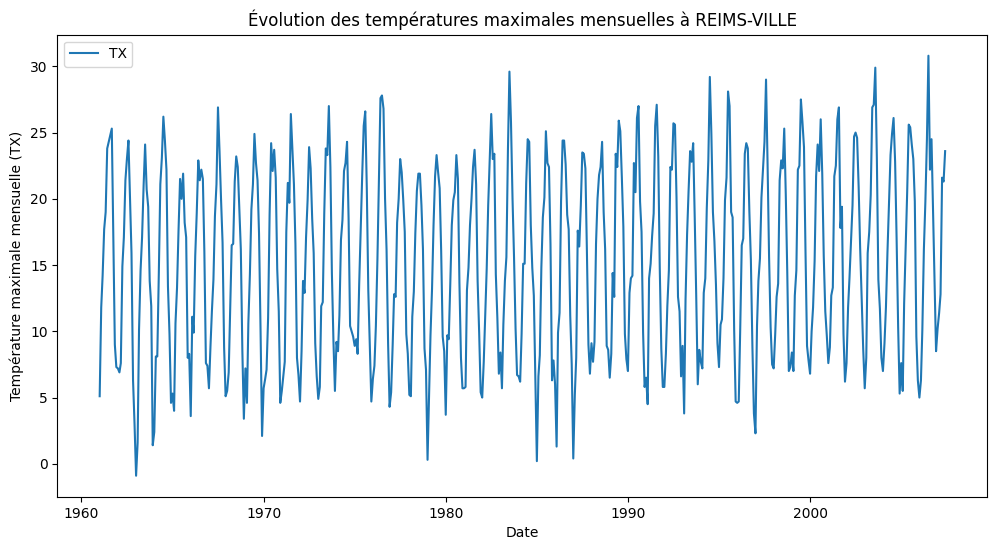

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['TX'], label='TX')
plt.title('Évolution des températures maximales mensuelles à REIMS-VILLE')
plt.xlabel('Date')
plt.ylabel('Température maximale mensuelle (TX)')
plt.legend()
plt.show()

Le graphique montre une **variation saisonnière** logique et évidente : les températures maximales mensuelles fluctuent régulièrement, reflétant une forte saisonnalité, avec des pics en été et des creux en hiver.

## Décomposition de la série temporelle

Pour mieux comprendre les variations à long terme, nous appliquons une décomposition additive de la série temporelle en ses composantes : tendance, saisonnalité et résidus :


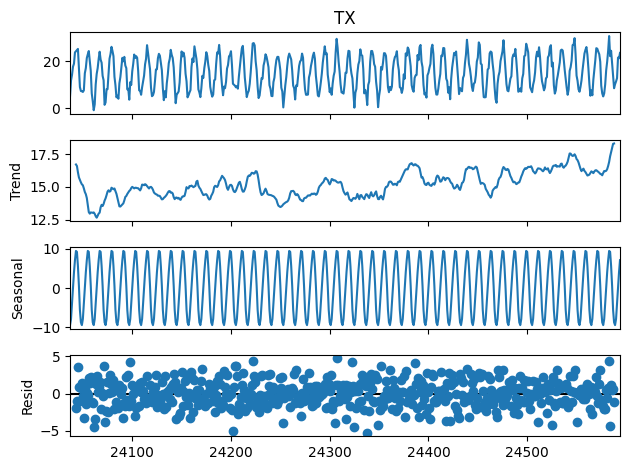

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['TX'], model='additive', period=12)
decomposition.plot()
plt.show()

Comme la forte saisonnalité peut masquer les tendances sous-jacentes , nous appliquons également une technique de lissage par moyenne mobile sur 12 mois. La fonction `rolling()` de Pandas permet de créer une fenêtre et d'y appliquer une fonction agrégation (ici la moyenne) :

<ipython-input-45-50b264ecb983>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TX_MA12'] = df['TX'].rolling(window=12).mean()


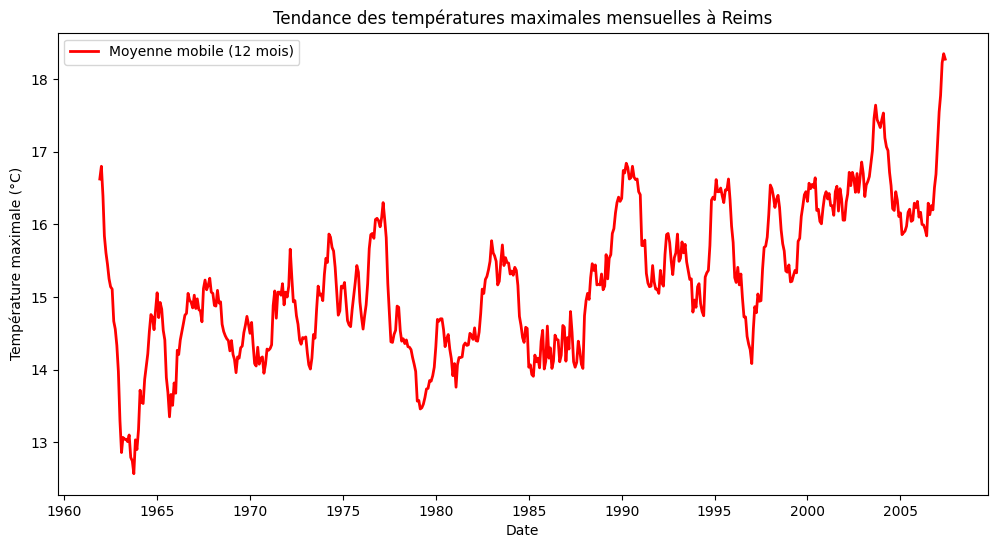

In [45]:
# Calcul de la moyenne mobile sur 12 mois
df['TX_MA12'] = df['TX'].rolling(window=12).mean()

# Visualisation de la moyenne mobile
plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['TX_MA12'], label='Moyenne mobile (12 mois)', color='red', linewidth=2)
plt.title('Tendance des températures maximales mensuelles à Reims')
plt.xlabel('Date')
plt.ylabel('Température maximale (°C)')
plt.legend()
plt.show()

Le lissage met en évidence les tendances à long terme. Une légère hausse des températures maximales est visible vers la fin du graphique, à partir des années 1990, ce qui pourrait correspondre aux tendances globales de réchauffement climatique.

## Prédiction avec Facebook Prophet

Pour aller plus loin, utilisons un modèle prédictif Facebook Prophet pour prédire les températures des mois à venir :

In [52]:
from prophet import Prophet

# Préparation du dataframe
prophet_df = df.rename(columns={'DATE': 'ds', 'TX': 'y'})

# Création du modèle
model = Prophet(interval_width=0.95)
model.fit(prophet_df)

# Création du dataframe avec les dates futures
future = model.make_future_dataframe(periods=12, freq='MS')

forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp38x37v9d/w0lrstw8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp38x37v9d/zqcq8e_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57764', 'data', 'file=/tmp/tmp38x37v9d/w0lrstw8.json', 'init=/tmp/tmp38x37v9d/zqcq8e_n.json', 'output', 'file=/tmp/tmp38x37v9d/prophet_modelgdoxt_0o/prophet_model-20250127165939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:59:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:59:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
565,2008-02-01,9.415634,5.946794,12.997631
566,2008-03-01,13.061572,9.297050,16.335844
567,2008-04-01,16.532032,12.832496,20.167636
568,2008-05-01,21.324367,17.998992,24.920091
569,2008-06-01,24.597288,20.899107,28.037585


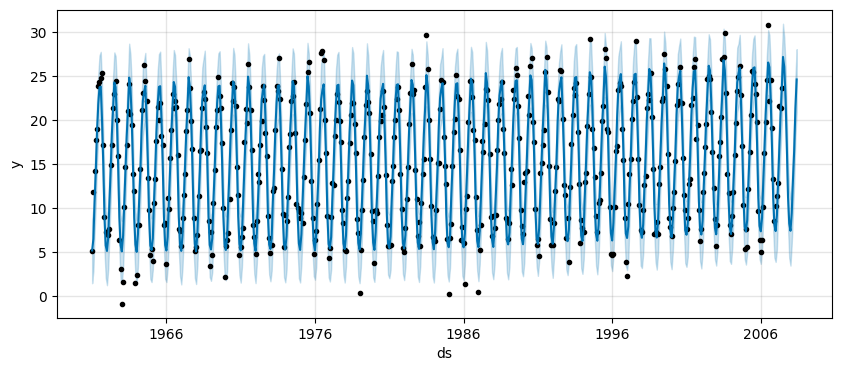

In [53]:
fig1, ax1 = plt.subplots(figsize=(10, 4))
model.plot(forecast, ax=ax1)
plt.show()